136011.21 132545.43 129184.81 125940.02 122812.60 119810.53 116947.48 114218.75 111615.97 109141.49 106791.90 104564.18 102454.29 100463.32 98585.18 96812.23 95143.71 93577.61 92124.55 90771.55 89511.10 88342.86 87266.17 86276.78 85371.97 84546.10 83784.97 83084.43 82447.64 81857.34 81311.39 80808.71 80343.38 79916.13 79527.89 79176.55 78853.53 78556.67 78282.97 78030.03 77797.87 77580.90 77377.85 77188.73 77014.96 76853.26 76704.40 76569.90 76446.33 76331.23 76225.44 76127.24 76036.68 75951.90 75874.32 75804.21 75739.03 75677.63 75619.24 75565.21 75514.11 75466.48 75421.79 75379.88 75340.21 75302.92 75269.12 75237.94 75209.17 75181.67 75156.53 75132.71 75109.08 75088.22 75067.86 75048.55 75030.95 75014.28 74997.94 74982.56 74967.70 74953.26 74939.12 74925.77 74912.74 74900.98 74889.10 74878.13 74867.19 74857.09 74847.21 74837.84 74828.66 74819.49 74810.94 74803.13 74795.46 74787.96 74780.72 74773.40 
81973.44 78617.70 75467.58 72522.46 69806.12 67331.93 65099.78 63094.01 61310.08 5972

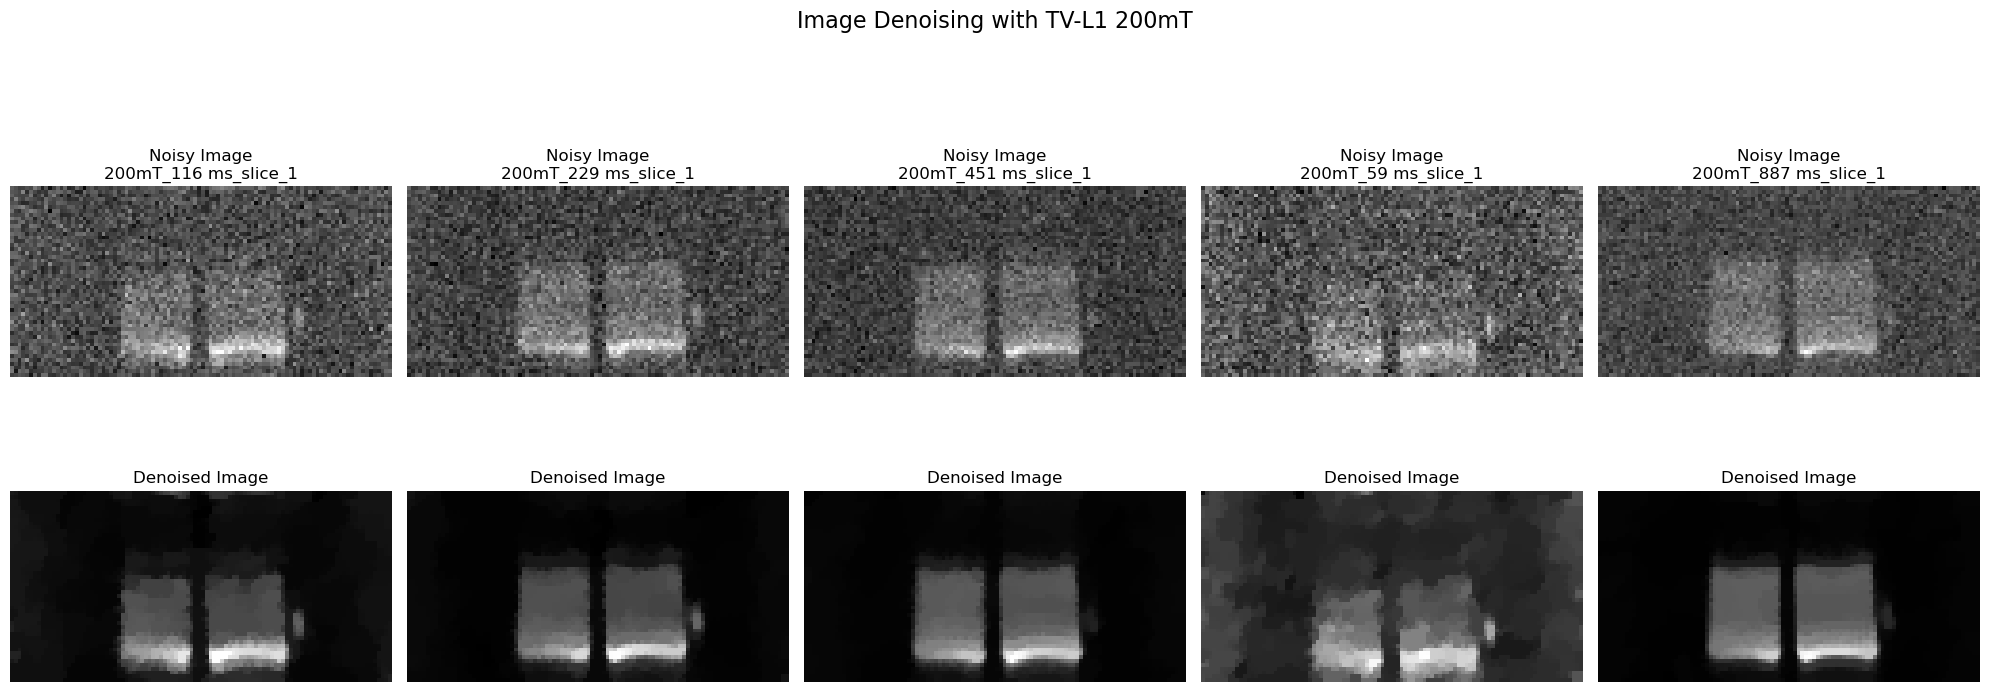

In [19]:
import numpy as np
import matplotlib.pyplot as plt


# Function to compute the gradient of an image
def compute_image_gradient(image):
    """Compute the gradient of an input image.
    
    Args:
        image (np.ndarray): The input image.
    
    Returns:
        np.ndarray: The gradient of the input image.
    """
    height, width = image.shape
    gradient = np.zeros((height, width, 2), image.dtype)
    gradient[:, :-1, 0] = image[:, 1:] - image[:, :-1]
    gradient[:-1, :, 1] = image[1:, :] - image[:-1, :]
    return gradient

# Function to compute the transpose of the gradient
def compute_transpose_gradient(gradient):
    """Compute the transpose of the gradient.
    
    Args:
        gradient (np.ndarray): The input gradient.
    
    Returns:
        np.ndarray: The transpose of the gradient.
    """
    height, width = gradient.shape[:2]
    transposed = np.zeros((height, width), gradient.dtype)
    transposed[:, :-1] -= gradient[:, :-1, 0]
    transposed[:, 1:] += gradient[:, :-1, 0]
    transposed[:-1] -= gradient[:-1, :, 1]
    transposed[1:] += gradient[:-1, :, 1]
    return transposed

# Function to compute the TV-L1 energy
def compute_TVL1_energy(denoised_image, original_image, regularization_weight):
    """Compute the TV-L1 energy of a denoised image.
    
    Args:
        denoised_image (np.ndarray): The denoised image.
        original_image (np.ndarray): The original noisy image.
        regularization_weight (float): The regularization parameter.
    
    Returns:
        float: The TV-L1 energy.
    """
    regularization_energy = np.sum(np.sqrt((compute_image_gradient(denoised_image) ** 2).sum(-1)))
    data_fidelity_energy = regularization_weight * np.sum(np.abs(denoised_image - original_image))
    return regularization_energy + data_fidelity_energy

# Function to project onto an R-radius ball
def project_onto_radius_ball(gradient_field, radius):
    """Project gradient vectors onto an R-radius ball.
    
    Args:
        gradient_field (np.ndarray): The gradient field.
        radius (float): The radius of the projection.
    
    Returns:
        np.ndarray: The projected gradient field.
    """
    normalized_gradient = np.maximum(1.0, np.sqrt((gradient_field ** 2).sum(-1)) / radius)
    return gradient_field / normalized_gradient[..., np.newaxis]

# Function to apply pixel-wise scalar shrinking
def shrink_scalar(X, forward_step, shrinkage_step_size):
    """Shrink values in a forward step array toward the values in the input array.
    
    Args:
        X (np.ndarray): The input array.
        forward_step (np.ndarray): The forward step array.
        shrinkage_step_size (float): The shrinkage step size.
    
    Returns:
        np.ndarray: The shrunk array.
    """
    return X + np.clip(forward_step - X, -shrinkage_step_size, shrinkage_step_size)

# Main function to solve the TV-L1 denoising problem
def solve_TVL1_denoising(image, lambda_weight, num_iterations=1000):
    """Solve the TV-L1 denoising problem for a given image.
    
    Args:
        image (np.ndarray): The input noisy image.
        lambda_weight (float): The regularization parameter.
        num_iterations (int): The number of iterations to perform.
    
    Returns:
        np.ndarray: The denoised image.
    """
    L2_norm = 8.1
    tau = 0.025
    sigma = 1.0 / (L2_norm * tau)
    theta = 1.0
    
    denoised_image = image.copy()
    gradient_field = compute_image_gradient(denoised_image)
    
    for iteration in range(num_iterations):
        gradient_field = project_onto_radius_ball(gradient_field + sigma * compute_image_gradient(denoised_image), 1.0)
        new_image = shrink_scalar(denoised_image - tau * compute_transpose_gradient(gradient_field), image, lambda_weight * tau)
        denoised_image = new_image + theta * (new_image - denoised_image)
        
        if iteration % 10 == 0:
            energy = compute_TVL1_energy(denoised_image, image, lambda_weight)
            print(f"Iteration {iteration}: Energy = {energy:.2f}")
    
    return denoised_image
lambda_TVL1 = 1

def load_tif_image(filepath):
    """Load a TIFF image as a numpy array."""
    with Image.open(filepath) as img:
        return np.array(img)

def process_tif_images(directory, clambda, iter_n=1000):
    files = os.listdir(directory)
    tif_files = [file for file in files if file.endswith('.tif')]
    tif_files.sort()

    num_images = len(tif_files)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 8), facecolor='white')

    for i, file in enumerate(tif_files):
        img_path = os.path.join(directory, file)
        img = load_tif_image(img_path)
        filename = os.path.splitext(file)[0]
        if img.ndim == 3:
            img = np.mean(img, axis=2)  # Convert RGB to grayscale

        denoised_img = solve_TVL1(img, clambda, iter_n)
        noisy_img = img + np.random.normal(scale=25, size=img.shape)  # Adjust noise level as needed
       
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.1, hspace=0.2)

        # Display the noisy image
        ax_noisy = axes[0, i]
        im_noisy = ax_noisy.imshow(noisy_img, cmap='gray')
        ax_noisy.set_title(f'Noisy Image\n{filename}')
        ax_noisy.axis('off')

        # Display the denoised image
        ax_denoised = axes[1, i]
        im_denoised = ax_denoised.imshow(denoised_img, cmap='gray')
        ax_denoised.set_title('Denoised Image')
        ax_denoised.axis('off')

    
        denoised_filename = f"denoised_{filename}.tiff"
        denoised_filepath = os.path.join(directory, denoised_filename)
        plt.imsave(denoised_filepath, denoised_img, cmap='gray')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.suptitle('Image Denoising with TV-L1 200mT', fontsize=16)
    plt.show()




directory = '../TraditionalMethods/Experiments/PhantomData/200mT' 
process_tif_images(directory, clambda=lambda_TVL1)


99599.12 96176.57 92920.16 89829.43 86910.21 84158.33 81582.66 79177.90 76959.02 74922.95 73056.96 71360.40 69827.09 68446.96 67221.52 66131.98 65145.53 64255.34 63462.49 62763.12 62144.04 61593.96 61101.06 60666.07 60282.66 59944.17 59650.62 59391.86 59160.72 58957.94 58778.05 58612.72 58463.69 58329.98 58211.11 58105.49 58011.11 57927.21 57849.83 57779.86 57715.02 57653.95 57598.92 57547.68 57500.11 57455.33 57412.87 57373.51 57336.06 57300.75 57268.08 57237.70 57209.03 57181.93 57156.31 57132.05 57108.83 57086.92 57065.43 57044.73 57025.15 57006.73 56988.94 56971.83 56955.03 56939.62 56924.52 56910.19 56896.32 56882.79 56869.48 56856.73 56844.33 56832.35 56820.88 56809.75 56798.59 56787.59 56777.06 56767.13 56757.46 56747.92 56738.77 56729.51 56720.73 56711.98 56703.42 56695.76 56688.40 56681.65 56674.71 56668.00 56661.48 56654.84 56648.97 56643.58 56638.21 56633.47 56628.32 56623.63 
112689.90 109141.90 105724.07 102443.96 99304.94 96317.11 93485.38 90811.95 88304.23 85957.68 83761

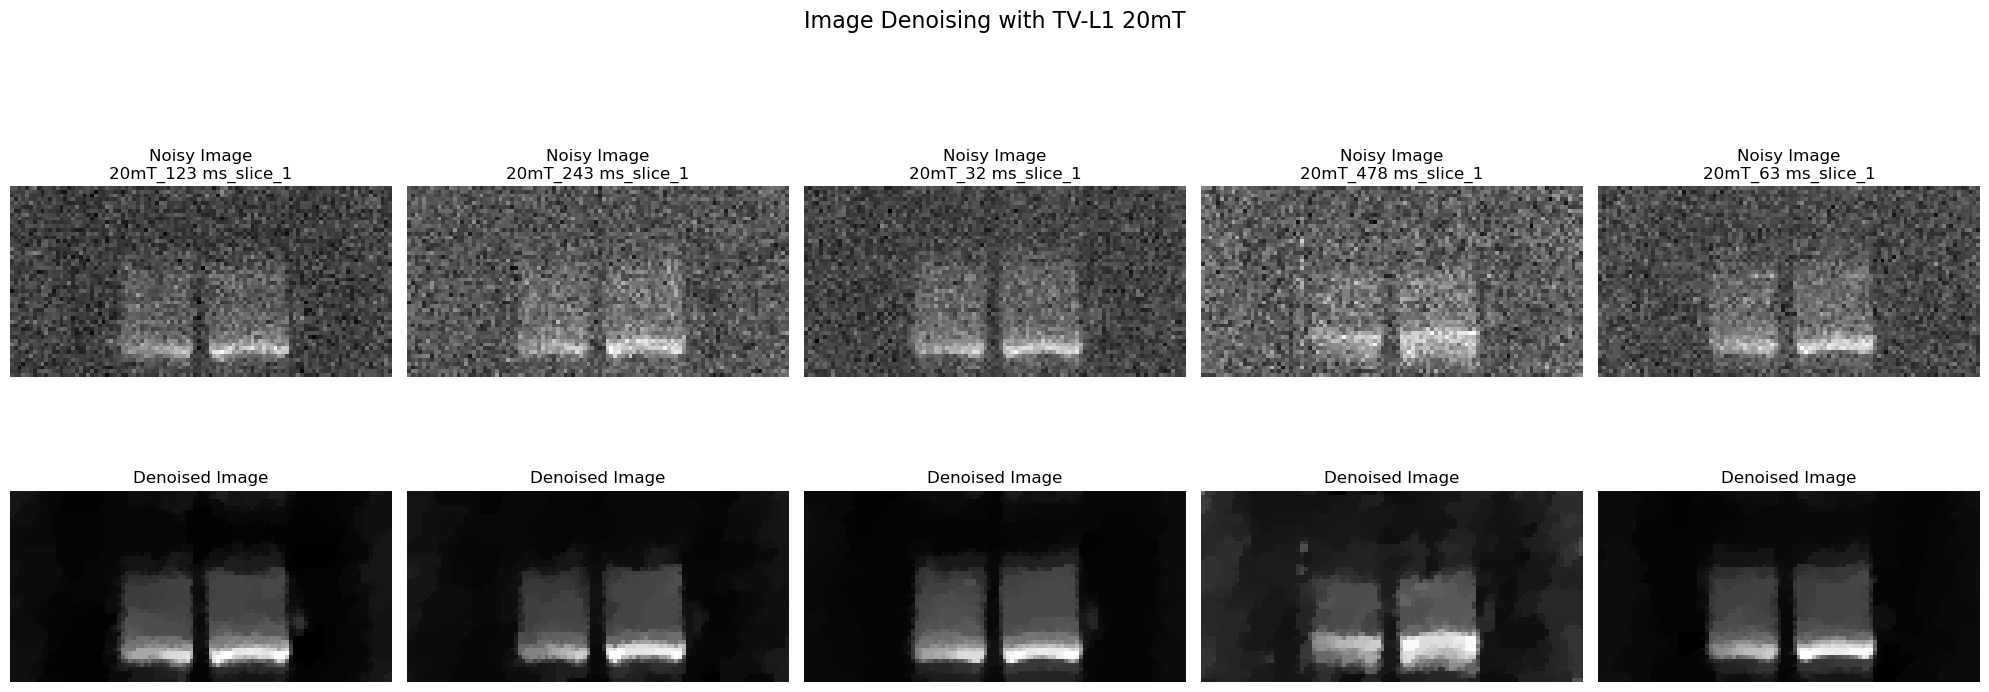

In [22]:
import numpy as np
import matplotlib.pyplot as plt


# Function to compute the gradient of an image
def compute_image_gradient(image):
    """Compute the gradient of an input image.
    
    Args:
        image (np.ndarray): The input image.
    
    Returns:
        np.ndarray: The gradient of the input image.
    """
    height, width = image.shape
    gradient = np.zeros((height, width, 2), image.dtype)
    gradient[:, :-1, 0] = image[:, 1:] - image[:, :-1]
    gradient[:-1, :, 1] = image[1:, :] - image[:-1, :]
    return gradient

# Function to compute the transpose of the gradient
def compute_transpose_gradient(gradient):
    """Compute the transpose of the gradient.
    
    Args:
        gradient (np.ndarray): The input gradient.
    
    Returns:
        np.ndarray: The transpose of the gradient.
    """
    height, width = gradient.shape[:2]
    transposed = np.zeros((height, width), gradient.dtype)
    transposed[:, :-1] -= gradient[:, :-1, 0]
    transposed[:, 1:] += gradient[:, :-1, 0]
    transposed[:-1] -= gradient[:-1, :, 1]
    transposed[1:] += gradient[:-1, :, 1]
    return transposed

# Function to compute the TV-L1 energy
def compute_TVL1_energy(denoised_image, original_image, regularization_weight):
    """Compute the TV-L1 energy of a denoised image.
    
    Args:
        denoised_image (np.ndarray): The denoised image.
        original_image (np.ndarray): The original noisy image.
        regularization_weight (float): The regularization parameter.
    
    Returns:
        float: The TV-L1 energy.
    """
    regularization_energy = np.sum(np.sqrt((compute_image_gradient(denoised_image) ** 2).sum(-1)))
    data_fidelity_energy = regularization_weight * np.sum(np.abs(denoised_image - original_image))
    return regularization_energy + data_fidelity_energy

# Function to project onto an R-radius ball
def project_onto_radius_ball(gradient_field, radius):
    """Project gradient vectors onto an R-radius ball.
    
    Args:
        gradient_field (np.ndarray): The gradient field.
        radius (float): The radius of the projection.
    
    Returns:
        np.ndarray: The projected gradient field.
    """
    normalized_gradient = np.maximum(1.0, np.sqrt((gradient_field ** 2).sum(-1)) / radius)
    return gradient_field / normalized_gradient[..., np.newaxis]

# Function to apply pixel-wise scalar shrinking
def shrink_scalar(X, forward_step, shrinkage_step_size):
    """Shrink values in a forward step array toward the values in the input array.
    
    Args:
        X (np.ndarray): The input array.
        forward_step (np.ndarray): The forward step array.
        shrinkage_step_size (float): The shrinkage step size.
    
    Returns:
        np.ndarray: The shrunk array.
    """
    return X + np.clip(forward_step - X, -shrinkage_step_size, shrinkage_step_size)

# Main function to solve the TV-L1 denoising problem
def solve_TVL1_denoising(image, lambda_weight, num_iterations=1000):
    """Solve the TV-L1 denoising problem for a given image.
    
    Args:
        image (np.ndarray): The input noisy image.
        lambda_weight (float): The regularization parameter.
        num_iterations (int): The number of iterations to perform.
    
    Returns:
        np.ndarray: The denoised image.
    """
    L2_norm = 8.1
    tau = 0.025
    sigma = 1.0 / (L2_norm * tau)
    theta = 1.0
    
    denoised_image = image.copy()
    gradient_field = compute_image_gradient(denoised_image)
    
    for iteration in range(num_iterations):
        gradient_field = project_onto_radius_ball(gradient_field + sigma * compute_image_gradient(denoised_image), 1.0)
        new_image = shrink_scalar(denoised_image - tau * compute_transpose_gradient(gradient_field), image, lambda_weight * tau)
        denoised_image = new_image + theta * (new_image - denoised_image)
        
        if iteration % 10 == 0:
            energy = compute_TVL1_energy(denoised_image, image, lambda_weight)
            print(f"Iteration {iteration}: Energy = {energy:.2f}")
    
    return denoised_image

lambda_TVL1 = 1

def load_tif_image(filepath):
    """Load a TIFF image as a numpy array."""
    with Image.open(filepath) as img:
        return np.array(img)

def process_tif_images(directory, clambda, iter_n=1000):
    files = os.listdir(directory)
    tif_files = [file for file in files if file.endswith('.tif')]
    tif_files.sort()

    num_images = len(tif_files)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 8), facecolor='white')

    for i, file in enumerate(tif_files):
        img_path = os.path.join(directory, file)
        img = load_tif_image(img_path)
        filename = os.path.splitext(file)[0]
        if img.ndim == 3:
            img = np.mean(img, axis=2)  # Convert RGB to grayscale

        denoised_img = solve_TVL1(img, clambda, iter_n)
        noisy_img = img + np.random.normal(scale=25, size=img.shape) 
       
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.1, hspace=0.2)

        # Display the noisy image
        ax_noisy = axes[0, i]
        im_noisy = ax_noisy.imshow(noisy_img, cmap='gray')
        ax_noisy.set_title(f'Noisy Image\n{filename}')
        ax_noisy.axis('off')

        # Display the denoised image
        ax_denoised = axes[1, i]
        im_denoised = ax_denoised.imshow(denoised_img, cmap='gray')
        ax_denoised.set_title('Denoised Image')
        ax_denoised.axis('off')

    
        denoised_filename = f"denoised_{filename}.tiff"
        denoised_filepath = os.path.join(directory, denoised_filename)
        plt.imsave(denoised_filepath, denoised_img, cmap='gray')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.suptitle('Image Denoising with TV-L1 20mT', fontsize=16)
    plt.show()




directory = '../TraditionalMethods/Experiments/PhantomData/20mT'  
process_tif_images(directory, clambda=lambda_TVL1)


158931.21 155245.78 151643.43 148126.46 144700.09 141376.76 138160.48 135051.66 132055.69 129172.76 126396.75 123735.53 121189.27 118759.87 116445.65 114246.78 112159.72 110173.38 108290.80 106518.39 104848.72 103281.88 101808.18 100418.41 99109.79 97880.96 96727.78 95657.89 94658.13 93731.51 92865.74 92056.88 91306.33 90607.18 89962.90 89363.12 88812.16 88302.84 87834.80 87405.79 87012.12 86646.46 86310.05 86000.26 85717.99 85460.09 85222.53 85008.13 84809.24 84625.91 84457.99 84302.80 84164.23 84038.60 83923.87 83819.30 83723.96 83636.61 83557.57 83482.88 83413.67 83350.34 83292.04 83238.39 83189.62 83144.00 83101.30 83061.66 83024.55 82990.11 82957.44 82927.59 82898.89 82871.18 82845.45 82820.55 82796.97 82774.12 82752.39 82732.31 82713.69 82696.56 82679.50 82663.26 82648.16 82633.52 82619.03 82605.78 82592.49 82580.03 82567.61 82555.95 82545.24 82534.67 82524.84 82515.04 82506.11 82497.03 82489.11 82481.38 
81825.57 78482.73 75339.71 72420.10 69736.72 67290.79 65094.29 63131.06 613

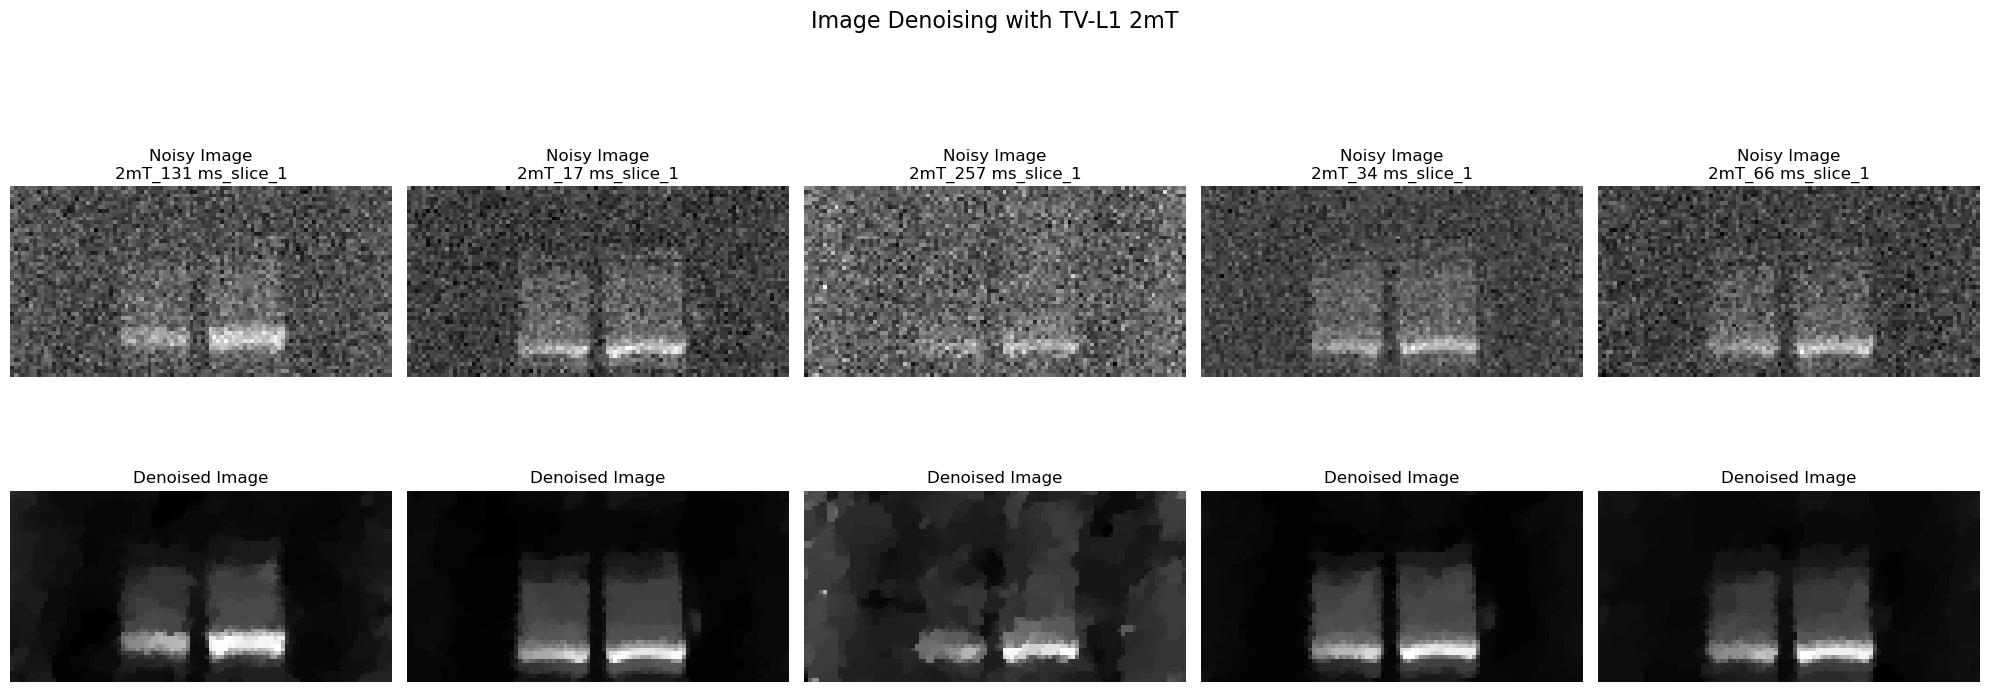

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.metrics import (
    peak_signal_noise_ratio as psnr,
    structural_similarity as ssim,
    mean_squared_error as mse
)

# Function to compute the gradient of an image
def compute_image_gradient(image):
    """Compute the gradient of an input image.
    
    Args:
        image (np.ndarray): The input image.
    
    Returns:
        np.ndarray: The gradient of the input image.
    """
    height, width = image.shape
    gradient = np.zeros((height, width, 2), image.dtype)
    gradient[:, :-1, 0] = image[:, 1:] - image[:, :-1]
    gradient[:-1, :, 1] = image[1:, :] - image[:-1, :]
    return gradient

# Function to compute the transpose of the gradient
def compute_transpose_gradient(gradient):
    """Compute the transpose of the gradient.
    
    Args:
        gradient (np.ndarray): The input gradient.
    
    Returns:
        np.ndarray: The transpose of the gradient.
    """
    height, width = gradient.shape[:2]
    transposed = np.zeros((height, width), gradient.dtype)
    transposed[:, :-1] -= gradient[:, :-1, 0]
    transposed[:, 1:] += gradient[:, :-1, 0]
    transposed[:-1] -= gradient[:-1, :, 1]
    transposed[1:] += gradient[:-1, :, 1]
    return transposed

# Function to compute the TV-L1 energy
def compute_TVL1_energy(denoised_image, original_image, regularization_weight):
    """Compute the TV-L1 energy of a denoised image.
    
    Args:
        denoised_image (np.ndarray): The denoised image.
        original_image (np.ndarray): The original noisy image.
        regularization_weight (float): The regularization parameter.
    
    Returns:
        float: The TV-L1 energy.
    """
    regularization_energy = np.sum(np.sqrt((compute_image_gradient(denoised_image) ** 2).sum(-1)))
    data_fidelity_energy = regularization_weight * np.sum(np.abs(denoised_image - original_image))
    return regularization_energy + data_fidelity_energy

# Function to project onto an R-radius ball
def project_onto_radius_ball(gradient_field, radius):
    """Project gradient vectors onto an R-radius ball.
    
    Args:
        gradient_field (np.ndarray): The gradient field.
        radius (float): The radius of the projection.
    
    Returns:
        np.ndarray: The projected gradient field.
    """
    normalized_gradient = np.maximum(1.0, np.sqrt((gradient_field ** 2).sum(-1)) / radius)
    return gradient_field / normalized_gradient[..., np.newaxis]

# Function to apply pixel-wise scalar shrinking
def shrink_scalar(X, forward_step, shrinkage_step_size):
    """Shrink values in a forward step array toward the values in the input array.
    
    Args:
        X (np.ndarray): The input array.
        forward_step (np.ndarray): The forward step array.
        shrinkage_step_size (float): The shrinkage step size.
    
    Returns:
        np.ndarray: The shrunk array.
    """
    return X + np.clip(forward_step - X, -shrinkage_step_size, shrinkage_step_size)

# Main function to solve the TV-L1 denoising problem
def solve_TVL1_denoising(image, lambda_weight, num_iterations=1000):
    """Solve the TV-L1 denoising problem for a given image.
    
    Args:
        image (np.ndarray): The input noisy image.
        lambda_weight (float): The regularization parameter.
        num_iterations (int): The number of iterations to perform.
    
    Returns:
        np.ndarray: The denoised image.
    """
    L2_norm = 8.1
    tau = 0.025
    sigma = 1.0 / (L2_norm * tau)
    theta = 1.0
    
    denoised_image = image.copy()
    gradient_field = compute_image_gradient(denoised_image)
    
    for iteration in range(num_iterations):
        gradient_field = project_onto_radius_ball(gradient_field + sigma * compute_image_gradient(denoised_image), 1.0)
        new_image = shrink_scalar(denoised_image - tau * compute_transpose_gradient(gradient_field), image, lambda_weight * tau)
        denoised_image = new_image + theta * (new_image - denoised_image)
        
        if iteration % 10 == 0:
            energy = compute_TVL1_energy(denoised_image, image, lambda_weight)
            print(f"Iteration {iteration}: Energy = {energy:.2f}")
    
    return denoised_image

lambda_TVL1 = 1

def load_tif_image(filepath):
    """Load a TIFF image as a numpy array."""
    with Image.open(filepath) as img:
        return np.array(img)

def process_tif_images(directory, clambda, iter_n=1000):
    files = os.listdir(directory)
    tif_files = [file for file in files if file.endswith('.tif')]
    tif_files.sort()

    num_images = len(tif_files)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 8), facecolor='white')

    for i, file in enumerate(tif_files):
        img_path = os.path.join(directory, file)
        img = load_tif_image(img_path)
        filename = os.path.splitext(file)[0]
        if img.ndim == 3:
            img = np.mean(img, axis=2)  # Convert RGB to grayscale

        denoised_img = solve_TVL1(img, clambda, iter_n)
        noisy_img = img + np.random.normal(scale=25, size=img.shape) 
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.1, hspace=0.2)

        # Display the noisy image
        ax_noisy = axes[0, i]
        im_noisy = ax_noisy.imshow(noisy_img, cmap='gray')
        ax_noisy.set_title(f'Noisy Image\n{filename}')
        ax_noisy.axis('off')

        # Display the denoised image
        ax_denoised = axes[1, i]
        im_denoised = ax_denoised.imshow(denoised_img, cmap='gray')
        ax_denoised.set_title('Denoised Image')
        ax_denoised.axis('off')

    
        denoised_filename = f"denoised_{filename}.tiff"
        denoised_filepath = os.path.join(directory, denoised_filename)
        plt.imsave(denoised_filepath, denoised_img, cmap='gray')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.suptitle('Image Denoising with TV-L1 2mT', fontsize=16)
    plt.show()




directory = '../TraditionalMethods/Experiments/PhantomData/2mT'  
process_tif_images(directory, clambda=lambda_TVL1)

299758.01 295885.78 292056.63 288268.99 284527.96 280830.30 277178.05 273575.66 270026.60 266532.02 263097.47 259721.91 256406.49 253147.91 249946.69 246804.30 243718.58 240694.77 237731.11 234828.45 231988.35 229212.32 226497.86 223841.71 221245.49 218707.79 216225.23 213796.03 211420.15 209100.96 206834.18 204625.32 202474.40 200375.36 198329.32 196337.37 194398.83 192512.27 190680.22 188901.75 187176.58 185497.46 183869.77 182291.42 180765.90 179297.53 177878.79 176507.97 175184.62 173909.86 172685.57 171504.40 170370.80 169272.80 168217.79 167202.04 166222.74 165283.73 164375.36 163500.35 162656.02 161842.03 161060.01 160301.34 159569.81 158864.89 158188.19 157535.69 156905.71 156299.49 155715.29 155150.52 154609.08 154088.04 153586.37 153102.54 152636.45 152189.38 151759.11 151347.28 150951.99 150572.70 150209.27 149857.99 149520.50 149194.91 148881.80 148582.54 148294.22 148018.09 147754.98 147502.97 147259.04 147025.56 146801.33 146586.72 146381.44 146185.46 145995.96 145815.36 

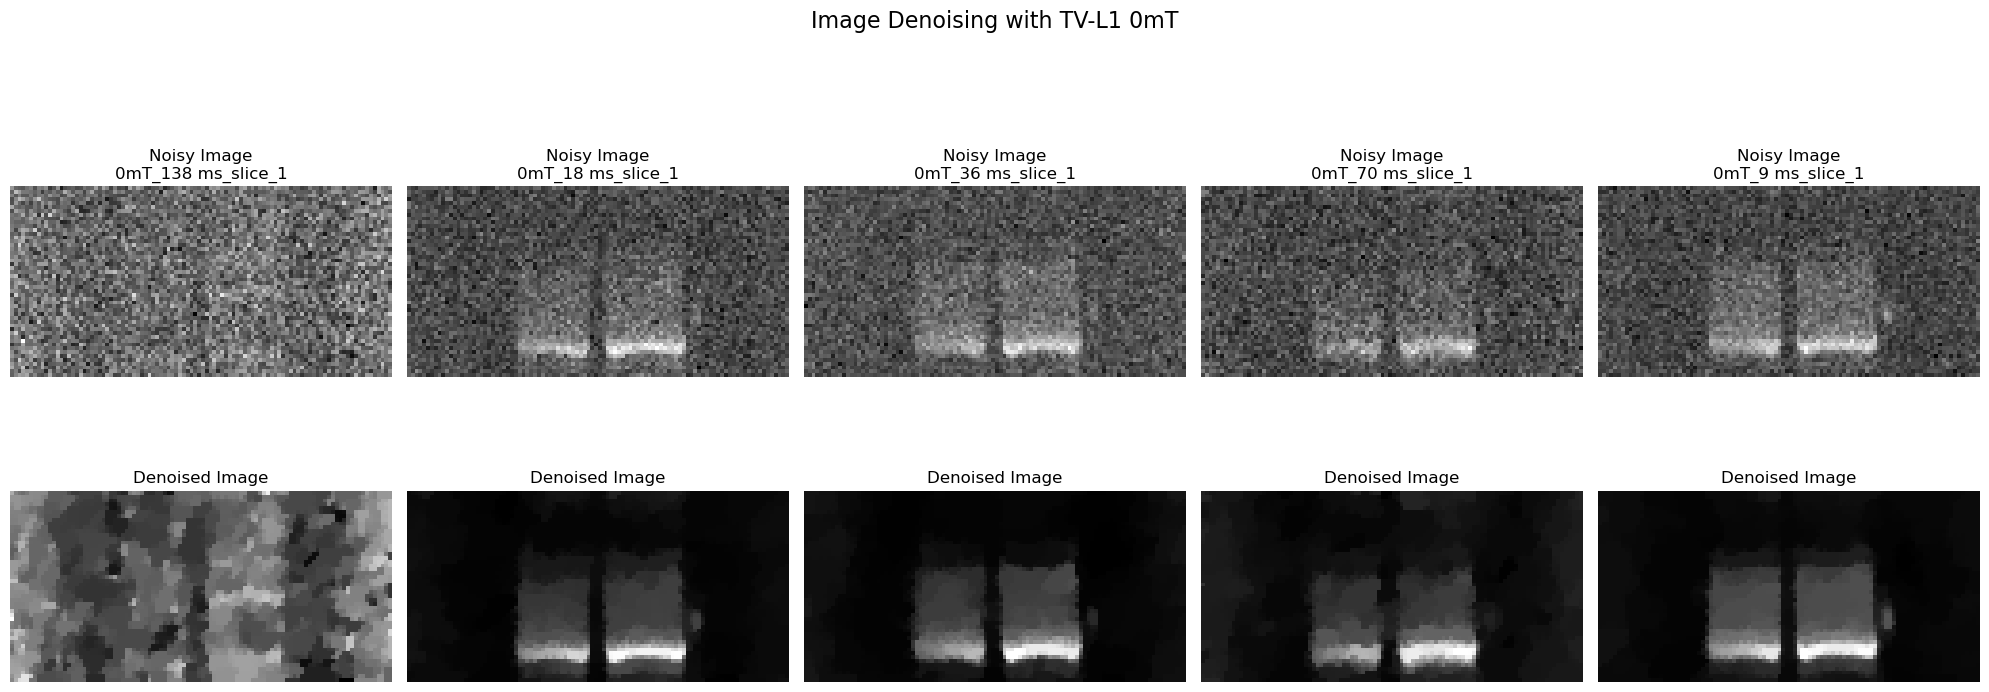

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.metrics import (
    peak_signal_noise_ratio as psnr,
    structural_similarity as ssim,
    mean_squared_error as mse
)

# Function to compute the gradient of an image
def compute_image_gradient(image):
    """Compute the gradient of an input image.
    
    Args:
        image (np.ndarray): The input image.
    
    Returns:
        np.ndarray: The gradient of the input image.
    """
    height, width = image.shape
    gradient = np.zeros((height, width, 2), image.dtype)
    gradient[:, :-1, 0] = image[:, 1:] - image[:, :-1]
    gradient[:-1, :, 1] = image[1:, :] - image[:-1, :]
    return gradient

# Function to compute the transpose of the gradient
def compute_transpose_gradient(gradient):
    """Compute the transpose of the gradient.
    
    Args:
        gradient (np.ndarray): The input gradient.
    
    Returns:
        np.ndarray: The transpose of the gradient.
    """
    height, width = gradient.shape[:2]
    transposed = np.zeros((height, width), gradient.dtype)
    transposed[:, :-1] -= gradient[:, :-1, 0]
    transposed[:, 1:] += gradient[:, :-1, 0]
    transposed[:-1] -= gradient[:-1, :, 1]
    transposed[1:] += gradient[:-1, :, 1]
    return transposed

# Function to compute the TV-L1 energy
def compute_TVL1_energy(denoised_image, original_image, regularization_weight):
    """Compute the TV-L1 energy of a denoised image.
    
    Args:
        denoised_image (np.ndarray): The denoised image.
        original_image (np.ndarray): The original noisy image.
        regularization_weight (float): The regularization parameter.
    
    Returns:
        float: The TV-L1 energy.
    """
    regularization_energy = np.sum(np.sqrt((compute_image_gradient(denoised_image) ** 2).sum(-1)))
    data_fidelity_energy = regularization_weight * np.sum(np.abs(denoised_image - original_image))
    return regularization_energy + data_fidelity_energy

# Function to project onto an R-radius ball
def project_onto_radius_ball(gradient_field, radius):
    """Project gradient vectors onto an R-radius ball.
    
    Args:
        gradient_field (np.ndarray): The gradient field.
        radius (float): The radius of the projection.
    
    Returns:
        np.ndarray: The projected gradient field.
    """
    normalized_gradient = np.maximum(1.0, np.sqrt((gradient_field ** 2).sum(-1)) / radius)
    return gradient_field / normalized_gradient[..., np.newaxis]

# Function to apply pixel-wise scalar shrinking
def shrink_scalar(X, forward_step, shrinkage_step_size):
    """Shrink values in a forward step array toward the values in the input array.
    
    Args:
        X (np.ndarray): The input array.
        forward_step (np.ndarray): The forward step array.
        shrinkage_step_size (float): The shrinkage step size.
    
    Returns:
        np.ndarray: The shrunk array.
    """
    return X + np.clip(forward_step - X, -shrinkage_step_size, shrinkage_step_size)

# Main function to solve the TV-L1 denoising problem
def solve_TVL1_denoising(image, lambda_weight, num_iterations=1000):
    """Solve the TV-L1 denoising problem for a given image.
    
    Args:
        image (np.ndarray): The input noisy image.
        lambda_weight (float): The regularization parameter.
        num_iterations (int): The number of iterations to perform.
    
    Returns:
        np.ndarray: The denoised image.
    """
    L2_norm = 8.1
    tau = 0.025
    sigma = 1.0 / (L2_norm * tau)
    theta = 1.0
    
    denoised_image = image.copy()
    gradient_field = compute_image_gradient(denoised_image)
    
    for iteration in range(num_iterations):
        gradient_field = project_onto_radius_ball(gradient_field + sigma * compute_image_gradient(denoised_image), 1.0)
        new_image = shrink_scalar(denoised_image - tau * compute_transpose_gradient(gradient_field), image, lambda_weight * tau)
        denoised_image = new_image + theta * (new_image - denoised_image)
        
        if iteration % 10 == 0:
            energy = compute_TVL1_energy(denoised_image, image, lambda_weight)
            print(f"Iteration {iteration}: Energy = {energy:.2f}")
    
    return denoised_image

lambda_TVL1 = 1

def load_tif_image(filepath):
    """Load a TIFF image as a numpy array."""
    with Image.open(filepath) as img:
        return np.array(img)

def process_tif_images(directory, clambda, iter_n=1000):
    files = os.listdir(directory)
    tif_files = [file for file in files if file.endswith('.tif')]
    tif_files.sort()

    num_images = len(tif_files)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 8), facecolor='white')

    for i, file in enumerate(tif_files):
        img_path = os.path.join(directory, file)
        img = load_tif_image(img_path)
        filename = os.path.splitext(file)[0]
        if img.ndim == 3:
            img = np.mean(img, axis=2)  # Convert RGB to grayscale

        denoised_img = solve_TVL1(img, clambda, iter_n)
        noisy_img = img + np.random.normal(scale=25, size=img.shape)  # Adjust noise level as needed
       
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.1, hspace=0.2)

        # Display the noisy image
        ax_noisy = axes[0, i]
        im_noisy = ax_noisy.imshow(noisy_img, cmap='gray')
        ax_noisy.set_title(f'Noisy Image\n{filename}')
        ax_noisy.axis('off')

        # Display the denoised image
        ax_denoised = axes[1, i]
        im_denoised = ax_denoised.imshow(denoised_img, cmap='gray')
        ax_denoised.set_title('Denoised Image')
        ax_denoised.axis('off')

    
        denoised_filename = f"denoised_{filename}.tiff"
        denoised_filepath = os.path.join(directory, denoised_filename)
        plt.imsave(denoised_filepath, denoised_img, cmap='gray')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.suptitle('Image Denoising with TV-L1 0mT', fontsize=16)
    plt.show()




directory = '../TraditionalMethods/Experiments/PhantomData/OmT'  
process_tif_images(directory, clambda=lambda_TVL1)